# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from tqdm import tqdm

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import models
from gensim.models import Phrases, CoherenceModel
from gensim import corpora

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Import data

In [2]:
train = pd.read_csv('data/train.csv')
submit = pd.read_csv('data/test.csv')

#### Training dataframe visualization

In [3]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


#### Tweets class repartition

In [4]:
class_0 = 0
class_1 = 0

for k in range(train.shape[0]):
    if train.target[k] == 0:
        class_0 += 1
    else:
        class_1 += 1

print('In the training set, there are '+str(class_0)+' tweets non-disaster related, and '+str(class_1)+' tweets disaster related.')

In the training set, there are 4342 tweets non-disaster related, and 3271 tweets disaster related.


# Data preproccesing

#### Cleaning functions

In [5]:
# Create a lemmatizer to fold inflected word forms together.
lemmatizer = WordNetLemmatizer()
nltk.download( 'stopwords', quiet=True )
nltk.download( 'wordnet', quiet=True )

tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
           }

# Get part of speech for a word. 
def get_wordnet_pos( word ):
    tag = nltk.pos_tag( [word] )[0][1][0].upper()
    return tag_dict.get( tag , wordnet.NOUN )

# Remove web links from a tweet.
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

# Remove retweet and @user information from a tweet.
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    
    # remove retweet
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    
    # remove tweeted at
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)     
    return tweet

#### Define stopwords and ponctuation

In [6]:
# Get the default English stopwords list from nltk.
stopwords = nltk.corpus.stopwords.words('english')
f = open('data/stopwords.txt') ; my_stopwords = set(f.read().split('\n')) ; f.close()
stopwords = list(set(stopwords).union(my_stopwords))

# Get a list of punctuation to clean from tweet.
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

#### Tokenization and lemmatization process

In [7]:
def tokenization_process(tweet, bigrams=False, remove_hashtag=False):
    tweet = remove_users(tweet)  # remove users (handles)
    tweet = remove_links(tweet)  # remove web links
    tweet = tweet.lower()        # convert tweet to lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers

    # tokenize the tweet.
    tweet_token_list = [word for word in tweet.strip().split(' ')
                            if len(word)>2 ]

    # lemmatize the words in the tweet.
    tweet_token_list = [lemmatizer.lemmatize(word)
        for word in tweet_token_list]

    # remove stop words from lemma list.
    tweet_token_list = [word for word in tweet_token_list
                       if word not in stopwords]

    # deal with bigrams if requested.
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    
    # remove hashtags
    if remove_hashtag:
        for token in tweet_token_list:
            token.replace('#', '')
                
    return tweet_token_list

def to_list(tweet_token_list):
    
    # join the processed words in the tweet back to a string with a blank separating the words.
    tweet = ' '.join(list(tweet_token_list))

    # return the cleaned tweet.
    return tweet

In [8]:
train['tokens'] = train.text.apply(tokenization_process)
submit['tokens'] = submit.text.apply(tokenization_process)

train['clean_tweet'] = train.tokens.apply(to_list)
submit['clean_tweet'] = submit.tokens.apply(to_list)

After all the lemmatization and tokenization process, this is how the tweets look like:

In [9]:
train[['id', 'clean_tweet']]

,id,clean_tweet
0,1,deed reason earthquake allah forgive
1,4,forest fire ronge sask canada
2,5,resident asked shelter place notified officer ...
3,6,people receive wildfire evacuation order calif...
4,7,got sent photo ruby alaska smoke wildfire pour...
...,...,...
7608,10869,giant crane holding bridge collapse nearby home
7609,10870,control wild fire california northern part sta...
7610,10871,utc volcano hawaii
7611,10872,police investigating bike collided car little ...


They have basically become a list of normalized relevant words that used to consitute the original tweet

# Step 1 : LDA

## Training process

#### Word2vec - Turning words into vectors

In [10]:
tokens = train['tokens'].tolist()

dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

#### Hyperparameter selection

In [34]:
# Number of wanted topics
num_topics = 4

# Dirichlet distribution parameters (usually < 1)
alpha = 0.5
eta = 0.5

# Number of iterations of the training process
passes = 3

#### Train model

In [35]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                               id2word=dictionary_LDA,
                               num_topics=num_topics,
                               chunksize=100,
                               passes=passes,
                               alpha=alpha,
                               eta=eta,
                               random_state = 42)

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
print('Coherence Score: ',coherence_model_lda.get_coherence())

Coherence Score:  0.4357127999562822


#### Weighted topics overview 

In [36]:
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)

for i,topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=True):
    print("Topic " + str(i) + ": " + topic)
    print()

Topic 0: 0.024*"fire" + 0.010*"news" + 0.008*"wreck" + 0.008*"train" + 0.008*"wreckage" + 0.008*"malaysia" + 0.008*"confirmed" + 0.008*"video" + 0.007*"wild" + 0.007*"home"

Topic 1: 0.013*"get" + 0.009*"wa" + 0.009*"day" + 0.008*"storm" + 0.006*"ha" + 0.006*"time" + 0.006*"people" + 0.005*"wrecked" + 0.005*"going" + 0.005*"love"

Topic 2: 0.010*"amp" + 0.007*"old" + 0.007*"look" + 0.007*"wa" + 0.007*"see" + 0.006*"bomb" + 0.005*"ha" + 0.005*"way" + 0.005*"woman" + 0.005*"best"

Topic 3: 0.012*"family" + 0.012*"disaster" + 0.010*"police" + 0.010*"wildfire" + 0.010*"wounded" + 0.009*"emergency" + 0.008*"nuclear" + 0.007*"officer" + 0.007*"dead" + 0.006*"suspect"



## Predictions

#### "Topic allocation" probabilities for the training set

In [37]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

This allows us to create the input for the next step: the MLP. Each text is now represented by a vector of K elements, K being the number of topics wanted, and each element k representing the probability of a the tweet belonging to that topic.

In [38]:
top = [lda_model[corpus[i]] for i in range(len(train))]

# Les lignes correspondent aux documents, les colonnes aux topics, et la case (i,j) correspondant au poids du topic j dans le document i
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in top]) \
  .reset_index(drop=True).fillna(0)

X = document_topic.to_numpy()

#### Topic prediction for the training set (takes the argmax of probabilities)

In [39]:
train['predicted_topic'] = None

for k in tqdm(range(train.shape[0]), position=0, leave=True):

    probas = []
    indexes = []
    prediction_k = lda_model[corpus[k]].copy()
    length = len(prediction_k)

    if length == 0:
        train['predicted_topic'][k] = -1
  
    else:
        for j in range(length):
            indexes.append(prediction_k[j][0])
            probas.append(prediction_k[j][1])
        train['predicted_topic'][k] = indexes[np.argmax(probas)]

  0%|          | 0/7613 [00:00<?, ?it/s]<ipython-input-39-8c084a9c1336>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['predicted_topic'][k] = indexes[np.argmax(probas)]
100%|██████████| 7613/7613 [00:04<00:00, 1651.05it/s]


#### Optional : "Topic allocation" probabilities & topic prediction for the submit set

In [40]:
def prediction(tweet, topics):
    predictions = pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tweet)]], columns=['topic #', 'weight', 'words in topic'])
    weight_list = [predictions.weight[k] for k in range(predictions.shape[0])]
    return weight_list

In [41]:
pred_list = []
X_submit = np.zeros((submit.shape[0], num_topics))

for k in tqdm(range(submit.shape[0])):
    weight_list = prediction(submit['tokens'][k], topics)
    for l in range(len(weight_list)):
        X_submit[k, l] = weight_list[l]
    
    # Predict principal topic of the text (the one with the heighest weight)
    argument = np.argmax(weight_list)
    pred_list.append(argument)

submit['predicted_topic'] = pred_list

100%|██████████| 3263/3263 [00:02<00:00, 1131.01it/s]


# Step 2 : Multi-Layer Perceptron

#### Creating the training, validation and test set for the MLP

In [71]:
y_raw = train[['target']].to_numpy(dtype=int)
y = np.zeros((train.shape[0], 2))
for k in range(y_raw.shape[0]):
    y[k, y_raw[k]] = 1

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

#### Training and plots

In [92]:
model = tf.keras.models.Sequential([                                                                                      
    Dense(100, 'relu'),
    Dense(100, 'relu'),
    Dense(2, 'softmax')
])

opt = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics = 'accuracy')

def scheduler(epoch, lr):
    if epoch <25:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [93]:
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/300
48/48 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.6603 - val_loss: 0.5997 - val_accuracy: 0.6873
Epoch 2/300
48/48 [==============================] - 0s 2ms/step - loss: 0.6003 - accuracy: 0.6952 - val_loss: 0.6038 - val_accuracy: 0.6991
Epoch 3/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.6971 - val_loss: 0.5977 - val_accuracy: 0.6951
Epoch 4/300
48/48 [==============================] - 0s 2ms/step - loss: 0.6000 - accuracy: 0.6849 - val_loss: 0.5947 - val_accuracy: 0.6978
Epoch 5/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.6964 - val_loss: 0.5973 - val_accuracy: 0.6978
Epoch 6/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.6991 - val_loss: 0.5935 - val_accuracy: 0.6978
Epoch 7/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.6926 - val_loss: 0.6000 - val_accuracy: 0.6859
Epoch 8/300
4

Epoch 59/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.6961 - val_loss: 0.5848 - val_accuracy: 0.7109
Epoch 60/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5805 - accuracy: 0.7057 - val_loss: 0.5894 - val_accuracy: 0.6833
Epoch 61/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5822 - accuracy: 0.7096 - val_loss: 0.5927 - val_accuracy: 0.6833
Epoch 62/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.7111 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 63/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7019 - val_loss: 0.5861 - val_accuracy: 0.6978
Epoch 64/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5861 - accuracy: 0.7006 - val_loss: 0.5851 - val_accuracy: 0.7122
Epoch 65/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5795 - accuracy: 0.7082 - val_loss: 0.5844 - val_accuracy: 0.7017
Epoch 

48/48 [==============================] - 0s 2ms/step - loss: 0.5788 - accuracy: 0.7130 - val_loss: 0.5865 - val_accuracy: 0.7004
Epoch 117/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5771 - accuracy: 0.7067 - val_loss: 0.5888 - val_accuracy: 0.6925
Epoch 118/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy: 0.7084 - val_loss: 0.5869 - val_accuracy: 0.6991
Epoch 119/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5768 - accuracy: 0.7066 - val_loss: 0.5857 - val_accuracy: 0.7070
Epoch 120/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.7089 - val_loss: 0.5878 - val_accuracy: 0.6991
Epoch 121/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7062 - val_loss: 0.5878 - val_accuracy: 0.6938
Epoch 122/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7120 - val_loss: 0.5858 - val_accuracy: 0.7070
Epoch 123/300

48/48 [==============================] - 0s 2ms/step - loss: 0.5825 - accuracy: 0.7099 - val_loss: 0.5856 - val_accuracy: 0.7030
Epoch 174/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.7090 - val_loss: 0.5867 - val_accuracy: 0.7043
Epoch 175/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5853 - accuracy: 0.7047 - val_loss: 0.5859 - val_accuracy: 0.7070
Epoch 176/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7110 - val_loss: 0.5884 - val_accuracy: 0.7017
Epoch 177/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.7185 - val_loss: 0.5881 - val_accuracy: 0.7122
Epoch 178/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.7137 - val_loss: 0.5858 - val_accuracy: 0.7135
Epoch 179/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.7057 - val_loss: 0.5886 - val_accuracy: 0.7043
Epoch 180/300

48/48 [==============================] - 0s 3ms/step - loss: 0.5728 - accuracy: 0.7117 - val_loss: 0.5840 - val_accuracy: 0.7083
Epoch 231/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.7072 - val_loss: 0.5882 - val_accuracy: 0.7070
Epoch 232/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 0.7182 - val_loss: 0.5907 - val_accuracy: 0.7017
Epoch 233/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7132 - val_loss: 0.5847 - val_accuracy: 0.7096
Epoch 234/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5760 - accuracy: 0.7073 - val_loss: 0.5897 - val_accuracy: 0.7030
Epoch 235/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5777 - accuracy: 0.7118 - val_loss: 0.5878 - val_accuracy: 0.7070
Epoch 236/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5644 - accuracy: 0.7274 - val_loss: 0.5842 - val_accuracy: 0.7017
Epoch 237/300

48/48 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7250 - val_loss: 0.5874 - val_accuracy: 0.7004
Epoch 288/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.7266 - val_loss: 0.5834 - val_accuracy: 0.7083
Epoch 289/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.7184 - val_loss: 0.5863 - val_accuracy: 0.7083
Epoch 290/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.7277 - val_loss: 0.5887 - val_accuracy: 0.6938
Epoch 291/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7171 - val_loss: 0.5852 - val_accuracy: 0.7096
Epoch 292/300
48/48 [==============================] - 0s 2ms/step - loss: 0.5581 - accuracy: 0.7266 - val_loss: 0.5845 - val_accuracy: 0.7135
Epoch 293/300
48/48 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.7261 - val_loss: 0.5857 - val_accuracy: 0.7017
Epoch 294/300

In [94]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 202       
Total params: 10,802
Trainable params: 10,802
Non-trainable params: 0
_________________________________________________________________


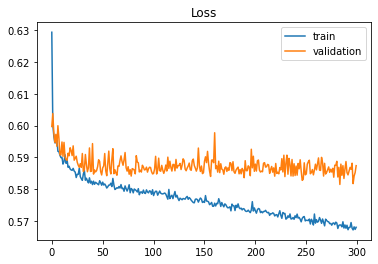

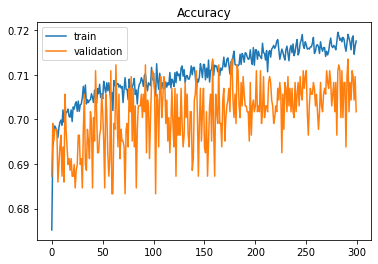

In [95]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

#### Evaluate on test data

In [96]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is " +str(results[0]))
print("The test accuracy is " +str(results[1]))

6/6 [==============================] - 0s 1ms/step - loss: 0.5870 - accuracy: 0.6916
The test loss is 0.5870152115821838
The test accuracy is 0.691601037979126


[4, 100, 2] - 300 epochs : The test loss is 0.5876468420028687 & the test accuracy is 0.6955380439758301

[4, 100, 100, 2] - 300 epochs : The test loss is 0.5841274857521057 & the test accuracy is 0.6968504190444946

[4, 50, 50, 2] - 300 epochs : The test loss is 0.5898472666740417 & the test accuracy is 0.6929134130477905

[4, 200, 200, 2] - 300 epochs : The test loss is 0.5832818150520325 & the test accuracy is 0.6955380439758301

#### False positives and false negatives

In [97]:
y_pred = model.predict(X_test)
pred_y = np.argmax(y_pred, axis=1)

fp = 0
fn = 0

for k in range(pred_y.shape[0]):
    if pred_y[k] == 0 and np.argmax(y_test[k]) == 1:
        fn += 1
    if pred_y[k] == 1 and np.argmax(y_test[k]) == 0:
        fp += 1

print("For the " + str(pred_y.shape[0]) + " elements that constitute the test set:")
print("- The number of false positives is " +str(fp))
print("- The number of false negatives is " +str(fn))

For the 762 elements that constitute the test set:
- The number of false positives is 60
- The number of false negatives is 175


#### Optional : code to submit predictions on the Kaggle competition

In [ ]:
y_submit = model.predict(X_submit)
submit_y = np.argmax(y_submit, axis=1)
test['target'] = list(submit_y)

In [ ]:
# Save results to submission file
test[['id', 'target']].to_csv("submission.csv", index=False)